Задача заключается в классификации текстовых отзывов по тональности на два класса: положительный и отрицательный (voted_up)

In [7]:
import pandas as pd
df = pd.read_csv("/content/steam_reviews_1086940 (3).csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   recommendationid             8000 non-null   int64  
 1   author                       8000 non-null   object 
 2   language                     8000 non-null   object 
 3   review                       7998 non-null   object 
 4   timestamp_created            8000 non-null   int64  
 5   timestamp_updated            8000 non-null   int64  
 6   voted_up                     8000 non-null   bool   
 7   votes_up                     8000 non-null   int64  
 8   votes_funny                  8000 non-null   int64  
 9   weighted_vote_score          8000 non-null   float64
 10  comment_count                8000 non-null   int64  
 11  steam_purchase               8000 non-null   bool   
 12  received_for_free            8000 non-null   bool   
 13  written_during_ear

In [8]:
print(f"Размер датафрейма: {len(df)}")
print(f"Дубликатов: {df.duplicated(subset=['recommendationid']).sum()}")

Размер датафрейма: 8000
Дубликатов: 0



Распределение отзывов:
voted_up
True     5270
False    2730
Name: count, dtype: int64


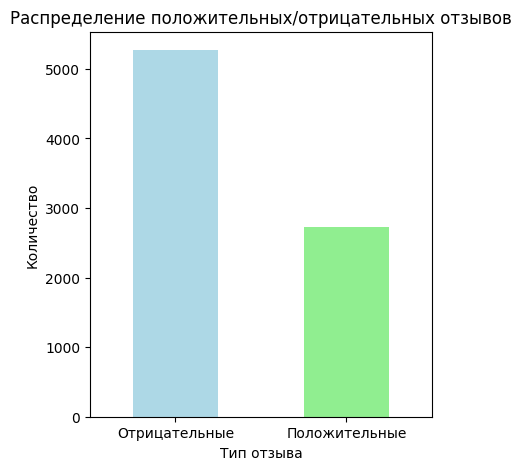

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\nРаспределение отзывов:")
voted_up_counts = df['voted_up'].value_counts()
print(voted_up_counts)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
colors = ['lightblue', 'lightgreen']
voted_up_counts.plot(kind='bar', color=colors)
plt.title('Распределение положительных/отрицательных отзывов')
plt.xlabel('Тип отзыва')
plt.ylabel('Количество')
plt.xticks([0, 1], ['Отрицательные', 'Положительные'], rotation=0)
plt.show()


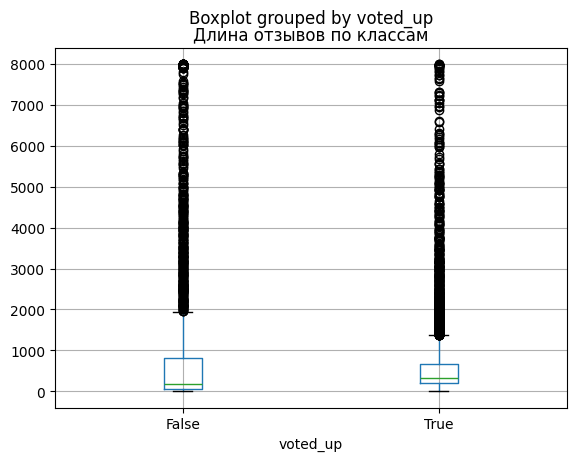

In [39]:
df['review_length'] = df['review'].str.len()
df.boxplot(column='review_length', by='voted_up')
plt.title('Длина отзывов по классам')
plt.show()

In [41]:
long_reviews = df[df['review_length'] > 1000]['voted_up'].value_counts()
print("Распределение длинных отзывов по классам:")
print(long_reviews)

Распределение длинных отзывов по классам:
voted_up
True     905
False    594
Name: count, dtype: int64



Статистика по числовым признакам:
          votes_up  votes_funny  comment_count  weighted_vote_score  \
count  8000.000000  8000.000000    8000.000000          8000.000000   
mean      9.618500     1.765375       0.610500             0.508442   
std      99.784249    19.344821       4.695029             0.071819   
min       0.000000     0.000000       0.000000             0.082700   
25%       0.000000     0.000000       0.000000             0.500000   
50%       1.000000     0.000000       0.000000             0.500000   
75%       4.000000     1.000000       0.000000             0.523810   
max    6656.000000   645.000000     165.000000             0.974945   

       review_length  
count    7998.000000  
mean      735.393598  
std      1230.766641  
min         1.000000  
25%       142.000000  
50%       286.500000  
75%       713.750000  
max      8000.000000  


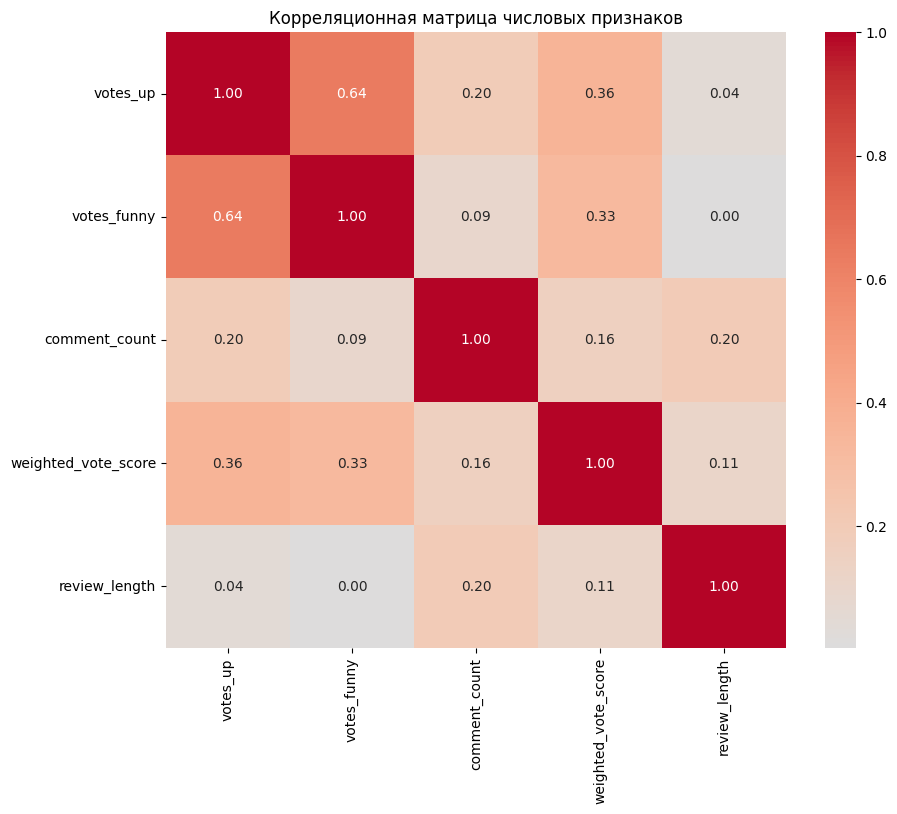

In [45]:
print("\nСтатистика по числовым признакам:")
numeric_features = ['votes_up', 'votes_funny', 'comment_count', 'weighted_vote_score', 'review_length']
print(df[numeric_features].describe())

# Корреляционная матрица
plt.figure(figsize=(10, 8))
corr_matrix = df[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Корреляционная матрица числовых признаков')
plt.show()

In [48]:
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from pymorphy3 import MorphAnalyzer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [53]:
df = df.drop(columns = ['recommendationid', 'author', 'timestamp_created', 'timestamp_updated', 'language', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'primarily_steam_deck'])

In [63]:
df_processed = df.copy()
morph = MorphAnalyzer()
stop_words = set(stopwords.words('russian'))
game_terms = {'игра', 'геймплей', 'графика', 'сюжет', 'персонаж', 'ачивка',
              'крафт', 'баг', 'лаги', 'патч', 'обновление', 'сервер',
              'донат', 'прокачка', 'квест', 'локация', 'босс', 'пвп', 'пве', 'не'}
stop_words = stop_words - game_terms
df_processed['review'] = df_processed['review'].str.replace(r'[^\w\s\-]', ' ', regex=True)
df_processed['review'] = df_processed['review'].str.replace(r'\s+', ' ', regex=True)
df_processed['review'] = df_processed['review'].str.strip()
df_processed['review'] = df_processed['review'].astype(str)
df_processed['tokens'] = df_processed['review'].apply(word_tokenize)


In [67]:
df_processed['filtered_tokens'] = df_processed['tokens'].apply(
    lambda tokens: [token for token in tokens
                   if token not in stop_words
                   and token not in ['что', 'это', 'как', 'так', 'или']]
)

In [68]:
df_processed['lemmatized_tokens'] = df_processed['filtered_tokens'].apply(
    lambda tokens: [morph.parse(token)[0].normal_form for token in tokens]
)

df_processed['processed_review'] = df_processed['lemmatized_tokens'].apply(' '.join)

In [66]:
df_processed.head(10)

,review,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,review_length,tokens,filtered_tokens,lemmatized_tokens,processed_review
0,h1 Оценка 7 10 h1 b Почему не рекомендую b Спр...,False,297,6,0.778929,50,7999.0,"[h1, Оценка, 7, 10, h1, b, Почему, не, рекомен...","[h1, Оценка, 10, h1, Почему, не, рекомендую, С...","[h1, оценка, 10, h1, почему, не, рекомендовать...",h1 оценка 10 h1 почему не рекомендовать справе...
1,Поставлю хороший отзыв когда игра выйдет полно...,False,158,3,0.730628,21,1609.0,"[Поставлю, хороший, отзыв, когда, игра, выйдет...","[Поставлю, хороший, отзыв, игра, выйдет, полно...","[поставить, хороший, отзыв, игра, выйти, полно...",поставить хороший отзыв игра выйти полностью р...
2,Шедевральный первый акт за которым следует раз...,False,181,4,0.765232,14,4767.0,"[Шедевральный, первый, акт, за, которым, следу...","[Шедевральный, первый, акт, которым, следует, ...","[шедевральный, первый, акт, который, следовать...",шедевральный первый акт который следовать разо...
3,Лицемерие игрового коммьюнити 2023 а может даж...,False,124,3,0.703599,130,5458.0,"[Лицемерие, игрового, коммьюнити, 2023, а, мож...","[Лицемерие, игрового, коммьюнити, 2023, десяти...","[лицемерие, игровой, коммьюнити, 2023, десятил...",лицемерие игровой коммьюнити 2023 десятилетие ...
4,Я всегда довольно критически подходил к оценка...,False,45,4,0.676077,6,2922.0,"[Я, всегда, довольно, критически, подходил, к,...","[довольно, критически, подходил, оценкам, любы...","[довольно, критически, подходить, оценка, любо...",довольно критически подходить оценка любой про...
5,Игра сильно переоценена и это далеко не шедевр...,False,44,1,0.672245,0,4119.0,"[Игра, сильно, переоценена, и, это, далеко, не...","[Игра, сильно, переоценена, далеко, не, шедевр...","[игра, сильно, переоценить, далеко, не, шедевр...",игра сильно переоценить далеко не шедевр игра ...
6,Сделав в игре всё что только можно я с уверенн...,False,62,3,0.669761,2,755.0,"[Сделав, в, игре, всё, что, только, можно, я, ...","[Сделав, игре, всё, уверенностью, заявляю, нет...","[сделать, игра, всё, уверенность, заявлять, не...",сделать игра всё уверенность заявлять нету реи...
7,Мессир Свен и Ко вывалили какой-то забагованны...,False,187,1,0.713428,26,6920.0,"[Мессир, Свен, и, Ко, вывалили, какой-то, заба...","[Мессир, Свен, Ко, вывалили, какой-то, забагов...","[мессир, свен, к, вывалить, какой-то, забагова...",мессир свен к вывалить какой-то забагованный о...
8,Странно читать настолько восторженные отзывы о...,False,89,3,0.656768,0,1210.0,"[Странно, читать, настолько, восторженные, отз...","[Странно, читать, настолько, восторженные, отз...","[странно, читать, настолько, восторженный, отз...",странно читать настолько восторженный отзыв ср...
9,Недостатки -Отсутствие обучения новичкам в днд...,False,57,5,0.638928,0,5545.0,"[Недостатки, -Отсутствие, обучения, новичкам, ...","[Недостатки, -Отсутствие, обучения, новичкам, ...","[недостаток, -отсутствие, обучение, новичок, д...",недостаток -отсутствие обучение новичок днд сл...


In [96]:
from sklearn.model_selection import train_test_split

X = df_processed[['processed_review']]
y = df_processed['voted_up']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size= 0.2,
    random_state=42,
    stratify=y
)
X_train = X_train.fillna('')
X_test = X_test.fillna('')

In [97]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6400 entries, 3766 to 6895
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   processed_review  6400 non-null   object
dtypes: object(1)
memory usage: 100.0+ KB


In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=8000,
    min_df=2,
    ngram_range=(1, 3)
)

В данном случае дополнительная нормализация не нужна, так как TF-IDF уже нормализован

In [129]:
X_train_tfidf = tfidf.fit_transform(X_train['processed_review'])
X_test_tfidf = tfidf.transform(X_test['processed_review'])

In [178]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score

lr_model = LogisticRegression(
    C=0.5,
    class_weight='balanced',  # учитываем дисбаланс
    random_state=42,
    max_iter=10000
)

lr_model.fit(X_train_tfidf, y_train)

y_pred_lr = lr_model.predict(X_test_tfidf)

In [207]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)

rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)

In [195]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist = [

    {
        'C': np.logspace(-3, 2, 20),
        'class_weight': ['balanced', None],
        'loss': ['hinge', 'squared_hinge'],
        'dual': [True],
        'tol': [1e-4, 1e-3, 1e-2],
        'max_iter': [1000, 2000, 5000]

    },
    {
        'C': np.logspace(-3, 2, 20),
        'class_weight': ['balanced', None],
        'loss': ['squared_hinge'],
        'dual': [False],
        'tol': [1e-4, 1e-3, 1e-2],
        'max_iter': [1000, 2000, 5000]

    }
]

random_search = RandomizedSearchCV(
    LinearSVC(random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train_tfidf, y_train)

print("Лучшие параметры:", random_search.best_params_)
print("Лучший F1-score:", random_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Лучшие параметры: {'tol': 0.0001, 'max_iter': 1000, 'loss': 'squared_hinge', 'dual': True, 'class_weight': 'balanced', 'C': np.float64(0.23357214690901212)}
Лучший F1-score: 0.8711057405293863


In [204]:
svm_model = LinearSVC(
    tol = 0.0001,
    loss = 'squared_hinge',
    dual = True,
    class_weight='balanced',
    max_iter=1000,
    C = 0.23357214690901212,
    random_state=42
)

svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

In [208]:
def evaluate_model_test(y_true, y_pred, model_name):
    print(f"=== {model_name} ===")
    print(classification_report(y_true, y_pred))

    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    print(f"F1-Score: {f1_weighted:.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("-" * 50)

# Оцениваем все модели
evaluate_model_test(y_test, y_pred_lr, "Logistic Regression")
evaluate_model_test(y_test, y_pred_rf, "Random Forest")
evaluate_model_test(y_test, y_pred_svm, "SVM") # Немного отличается от лучшего F1, так как там мы проверяли на кросс-валидации

=== Logistic Regression ===
              precision    recall  f1-score   support

       False       0.75      0.86      0.80       546
        True       0.92      0.86      0.89      1054

    accuracy                           0.86      1600
   macro avg       0.84      0.86      0.84      1600
weighted avg       0.86      0.86      0.86      1600

F1-Score: 0.8582

Confusion Matrix:
[[468  78]
 [152 902]]
--------------------------------------------------
=== Random Forest ===
              precision    recall  f1-score   support

       False       0.69      0.82      0.75       546
        True       0.90      0.80      0.85      1054

    accuracy                           0.81      1600
   macro avg       0.79      0.81      0.80      1600
weighted avg       0.83      0.81      0.81      1600

F1-Score: 0.8141

Confusion Matrix:
[[449  97]
 [206 848]]
--------------------------------------------------
=== SVM ===
              precision    recall  f1-score   support

       Fa

In [206]:
def evaluate_mode_train(y_true, y_pred, model_name):
    print(f"=== {model_name} (TRAIN) ===")
    print(classification_report(y_true, y_pred))

    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    print(f"F1-Score: {f1_weighted:.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("-" * 50)

y_pred_lr_train = lr_model.predict(X_train_tfidf)
y_pred_rf_train = rf_model.predict(X_train_tfidf)
y_pred_svm_train = svm_model.predict(X_train_tfidf)

print("ОЦЕНКА НА ТРЕНИРОВОЧНЫХ ДАННЫХ:")
evaluate_mode_train(y_train, y_pred_lr_train, "Logistic Regression")
evaluate_mode_train(y_train, y_pred_rf_train, "Random Forest")
evaluate_mode_train(y_train, y_pred_svm_train, "SVM")

ОЦЕНКА НА ТРЕНИРОВОЧНЫХ ДАННЫХ:
=== Logistic Regression (TRAIN) ===
              precision    recall  f1-score   support

       False       0.82      0.93      0.87      2184
        True       0.96      0.89      0.92      4216

    accuracy                           0.90      6400
   macro avg       0.89      0.91      0.90      6400
weighted avg       0.91      0.90      0.91      6400

F1-Score: 0.9054

Confusion Matrix:
[[2031  153]
 [ 461 3755]]
--------------------------------------------------
=== Random Forest (TRAIN) ===
              precision    recall  f1-score   support

       False       0.75      0.89      0.81      2184
        True       0.94      0.84      0.89      4216

    accuracy                           0.86      6400
   macro avg       0.84      0.87      0.85      6400
weighted avg       0.87      0.86      0.86      6400

F1-Score: 0.8614

Confusion Matrix:
[[1942  242]
 [ 661 3555]]
--------------------------------------------------
=== SVM (TRAIN) ===


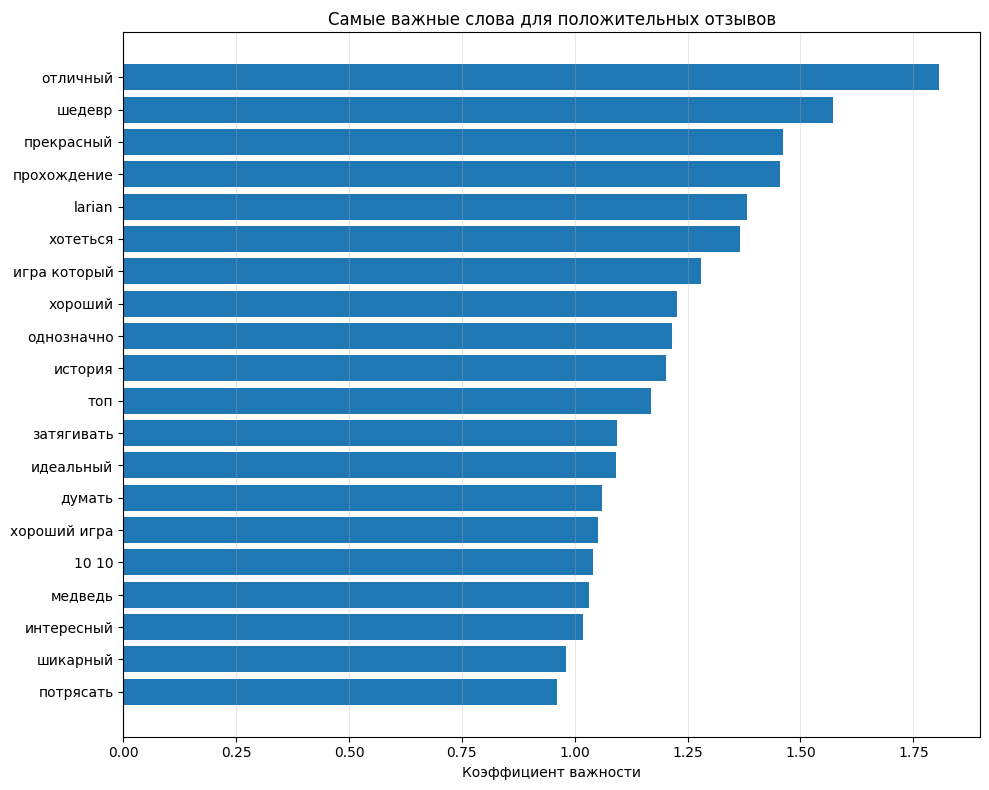

In [209]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer


feature_names = tfidf.get_feature_names_out()

def plot_positive_words(model, feature_names, n_top_words=20):
    plt.figure(figsize=(10, 8))

    positive_coef = model.coef_[0]

    top_positive = np.argsort(positive_coef)[-n_top_words:]

    plt.barh(range(n_top_words), positive_coef[top_positive])
    plt.yticks(range(n_top_words), [feature_names[i] for i in top_positive])
    plt.xlabel('Коэффициент важности')
    plt.title('Самые важные слова для положительных отзывов') # Отрицательные не вывел из-за цензуры

    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_positive_words(svm_model, feature_names, 20)

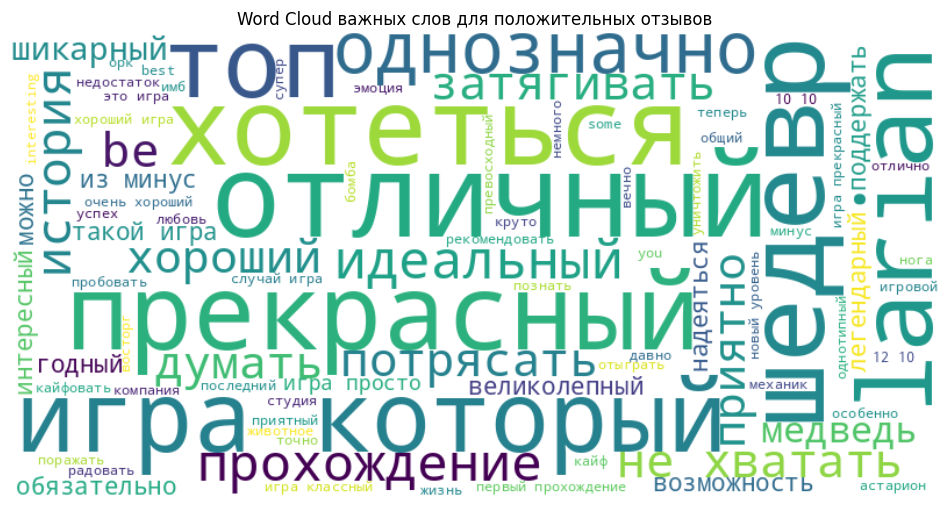

In [128]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

positive_mask = svm_model.coef_[0] > 0
positive_feature_names = feature_names[positive_mask]
positive_coefficients = svm_model.coef_[0][positive_mask]

positive_word_weights = dict(zip(positive_feature_names, positive_coefficients))

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=100,
    min_font_size=10,
    max_font_size=100
).generate_from_frequencies(positive_word_weights)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud важных слов для положительных отзывов')
plt.show()

# Выводы
Все модели показали относительно неплохие результаты(accuracy и f1_score > 0.8 у всех моделий), но они немного переобучены, так как есть разница(0.05 - 0.1 в accuracy и f1_score на train и test выборках), это может быть связано с тем, что люди пишут отзывы с иронией или просто какой-то несвязанный текст, а также встречаются отзывы, в которых половина может быть написана в положительном тоне, другая - в отрицательном. В целом, данная точность типична для такого вида задач и в большинстве случаев подходит для бизнес-решений. Данные методы машинного обучения были выбраны из-за относительной простоты и достаточной эффективности для данного рода задач, например, KNN, скорее всего, справился бы с данной задачей не так хорошо из-за "проклятия размерности". Также в изначальном наборе данных присутствовали и другие метрики, например votes_up(другие пользователи лайкают отзыв), я решил не включать их из-за того, что у более популярных игр больше игроков, и реакций на отзывы тоже больше, да и, в целом, основная информация находится именно в тексте самого отзыва.